<a href="https://colab.research.google.com/github/miladramzy/HMC-PINNs/blob/main/BPINNs_HT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Bayesian physics-informed neural netowrks using Hamiltonian Monte Carlo in composites autoclave processing
This is a JAX implementation of BPINN model developed for curing composite materials. See below for more details:
https://open.library.ubc.ca/soa/cIRcle/collections/ubctheses/24/items/1.0432643

Milad Ramezankhani | https://miladramzy.github.io/


In [1]:
# Import libraries
import jax
import jax.numpy as np
from jax import random, grad, vmap

import tqdm
import numpy as onp
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import qmc
from matplotlib import pyplot as plt

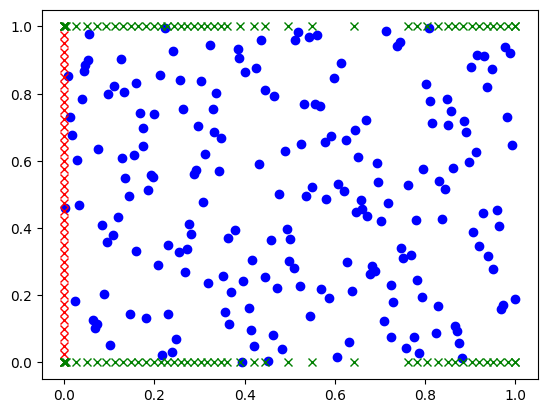

In [2]:
# Composites heat transfer with no internal heat generation

# Load FE simulation data
fn = 'BPINN_HT_Data.csv'
part_length, nodes = 0.02, 41

raw = pd.read_csv(fn)

t =  np.array(raw['Time'].copy()) # Time (s) -- [T,1]
x = np.linspace(0,part_length, num = nodes) # Generate the location (m) of n nodes -- [X,1]
raw_np = np.array(raw)
Temp = raw_np[:,1:] # Tempe in C (fist column is Time, removed) -- [T,X]
Temp_k = Temp + 273 # Temperature in K [T,X]

# Normalization
scaler_x = 1/x.max()
scaler_y = 1/t.max()
x, t = x*scaler_x, t*scaler_y

u = Temp.flatten('C')[:,None] # flatten Temp C
u_k_flat = u + 273 # Temp in k

T_scale = MinMaxScaler()
Temp_k_norm = T_scale.fit_transform(u_k_flat)

# Domain bounds
x_lb, x_ub = x[0], x[-1]
t_lb, t_ub = t[0], t[-1]
lb = np.array([x_lb, t_lb])
ub = np.array([x_ub, t_ub])

X, T = np.meshgrid(x, t) # X: [T, X], T: [T, X]

X = X.flatten()[:, None]
T = T.flatten()[:, None]

F = np.asarray(np.hstack([X, T]))
U = np.asarray(Temp_k_norm)

"""Specifiy material properties and heat transfer parameters"""
k = 0.702 # (W/(m K))
rho = 1581.26 # (kg/m3)
Cp = 1080.2252 # (J/ (kg K))
h_b = 50 # (W/(m^2 K))
h_t = 100 # (W/(m^2 K))
a =  k/(rho*Cp) # Thermal diffusivity in heat trasnfer PDE (m2 / s)
a_c_normalized = a * ((scaler_x)**2)/scaler_y

#%% IC, BC and collocation points

# IC data
train_ic_index = np.where(F[:,1]==0)[0]

# BC data
n_bc = 40
step_bc = int(t.shape[0]/n_bc)
indx_bc = onp.arange(0, t.shape[0]+1, step_bc)
train_bc_index = onp.hstack([onp.where(onp.logical_and(onp.logical_or(F[:,0]==0, F[:,0]==1), F[:,1]==i))[0] for i in t[indx_bc]])

# Collocation data
n_f = 200
engine = qmc.LatinHypercube(d=2)
sample = engine.random(n=n_f)
F_pde = lb + (ub-lb)*sample

F_ic = F[train_ic_index,:]
F_bc = F[train_bc_index,:]

U_ic = U[train_ic_index]
U_bc = U[train_bc_index]

#%% Plot training points
plt.plot(F_pde[:, 1], F_pde[:, 0], 'bo', label = 'Collocation')
plt.plot(F_ic[:, 1], F_ic[:, 0], 'rx', label = 'Initial')
plt.plot(F_bc[:, 1], F_bc[:, 0], 'gx', label = 'Boundary')

#%% Specify data noise and corrosponding std
def inv_softplus(x):
    return np.log(np.exp(x) - 1)

noise_std = 0.01 # Data noise
invsp_noise_std = inv_softplus(noise_std)

# Define neural network
def MLP(layer_widths, activation=np.tanh):

    def init( rng_key, scale=1e-2):
        rng_key, *keys = jax.random.split(rng_key, len(layer_widths))
        params = {}

        w_count = len(layer_widths) - 1
        layer_names = ['linear_'+ str(i) for i in range(w_count)]
        for i, (n_in, n_out, key, name) in enumerate(zip(layer_widths[:-1], layer_widths[1:], keys, layer_names)):
            key_w, key_b = jax.random.split(key)
            layer = {}
            # a) glorot initialization
            glorot_stddev = 1.0 / np.sqrt((n_in + n_out) / 2.)
            w = glorot_stddev * jax.random.normal(key_w, (n_in, n_out))
            b = np.zeros((n_out,))
            # b) Normal initialization
            #w = scale * jax.random.normal(key_w, (n_in, n_out))
            #b = scale * jax.random.normal(key_b, (n_out,))
            layer['w'] = w
            layer['b'] = b
            params[name] = layer
        return params

    def apply(params, inputs):
        params_flat = jax.tree_util.tree_flatten(params)[0]
        params_flat_sub = [params_flat[x:x+2] for x in range(0, len(params_flat), 2)]

        H, _= inputs
        for b, W in params_flat_sub[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        b, W = params_flat_sub[-1]
        outputs = np.dot(H, W) + b
        outputs = np.concatenate([outputs, np.ones_like(outputs) * invsp_noise_std], -1)
        return outputs
    return init, apply

# outputs network's prediction
def predict(params, batch):
    x, y = batch
    new_batch = (x.reshape(-1,1), y)
    outputs = net_apply(params, new_batch)
    return outputs

# outputs network's prediction as a value (not array)
def neural_net(params, x, t):
    z = np.hstack([x, t])
    outputs = net_apply(params, (z, None))
    outputs, _ = np.split(outputs, 2)
    return outputs[0]

# calculates the PDE loss
def residual_net(params, x, t):
    u_t = grad(neural_net, argnums=2)(params, x, t)
    u_xx = grad(grad(neural_net, argnums = 1), argnums=1)(params, x, t)
    f = u_t - a_c_normalized*u_xx
    return f

# vmap the functions
u_pred_fn = vmap(neural_net, (None, 0, 0))
r_pred_fn = vmap(residual_net, (None, 0, 0))


In [3]:
# Model parameters

# 1) Initialize the network
d0 = 2 # Input dimension
layers = [d0, 128, 128, 1] # 2 hidden layers
key = random.PRNGKey(123456)
key, sub_key = jax.random.split(key, 2)
init, net_apply = MLP(layers, activation=np.tanh)
params = init(rng_key = key)

# 2) Specify uncertainty
prior_std = 1e-2 # prior std of model parameters
weight_decay = 1 / prior_std**2
noise_std_ic = 0.0001 # noise std of IC data
noise_std_bc = 0.0001 # noise std of BC data
noise_pde_std = 0.001 # Certainty level about the known physics

# 3) HMC trainig setting
step_size = 1e-6
num_iterations = 20
trajectory_len = np.pi / 2 / np.sqrt(weight_decay) # From [https://arxiv.org/abs/2104.14421]
max_num_leapfrog_steps = int(trajectory_len // step_size + 1)
print("Leapfrog steps per iteration:", max_num_leapfrog_steps)


Leapfrog steps per iteration: 15708


In [4]:
# HMC-PINNs
# See here for HMC functions [https://github.com/google-research/google-research/tree/master/bnn_hmc]
# ==================================================
# prior ============================================
# ==================================================
# Function to do dot product between two pytrees
def tree_dot(a, b):
  return sum([np.sum(e1 * e2) for e1, e2 in
              zip(jax.tree_util.tree_leaves(a), jax.tree_util.tree_leaves(b))])

# Function returns two functions: log prior and log prior diff
def make_gaussian_log_prior(weight_decay, temperature):
  """Returns the Gaussian log-density and delta given weight decay."""

  def log_prior(params):
    """Computes the Gaussian prior log-density."""
    # ToDo izmailovpavel: make temperature treatment the same as in gaussian
    # likelihood function.
    n_params = sum([p.size for p in jax.tree_util.tree_leaves(params)])
    log_prob = -(0.5 * tree_dot(params, params) * weight_decay +
                 0.5 * n_params * np.log(weight_decay / (2 * onp.pi)))
    return log_prob / temperature

  def log_prior_diff(params1, params2):
    """Computes the delta in  Gaussian prior log-density."""
    """Usage: Accept probability function in HMC"""
    diff = sum([
        np.sum(p1**2 - p2**2)
        for p1, p2 in zip(jax.tree_util.tree_leaves(params1), jax.tree_util.tree_leaves(params2))
    ])
    return -0.5 * weight_decay * diff / temperature

  return log_prior, log_prior_diff

log_prior_fn, log_prior_diff_fn = make_gaussian_log_prior(weight_decay, 1.)

# ==================================================
# Log likelihood ===================================
# ==================================================
def gaussian_log_likelihood(params):
  """Computes the negative log-likelihood.
  It consists of 3 terms:
    1) IC log likelihood: calculates the LL of IC data
    2) BC log likelihood: calculates the LL of BC data
    3) PDE log likelihood: calculates the LL of PDE data
  """

  # IC loss
  predictions = u_pred_fn(params, F_ic[:,0], F_ic[:,1]).reshape([-1,1])
  tempered_std = np.ones(predictions.shape)*noise_std_ic
  se = (predictions - U_ic)**2
  log_likelihood = (-0.5 * se / tempered_std**2 - 0.5 * np.log(tempered_std**2 * 2 * onp.pi))
  log_likelihood = np.sum(log_likelihood)

  # BC loss
  predictions_bc = u_pred_fn(params, F_bc[:,0], F_bc[:,1]).reshape([-1,1])
  tempered_std_bc = np.ones(predictions_bc.shape)*noise_std_bc
  bce = (predictions_bc - U_bc)**2
  log_likelihood_bc = (-0.5 * bce / tempered_std_bc**2 - 0.5 * np.log(tempered_std_bc**2 * 2 * onp.pi))
  log_likelihood_bc = np.sum(log_likelihood_bc)

  # PDE loss (Governing laws)
  res = r_pred_fn(params, F_pde[:,0], F_pde[:,1])
  pde_std = np.ones(res.shape)*noise_pde_std
  fe = (res)**2
  log_likelihood_pde = (-0.5 * fe / pde_std**2 - 0.5 * np.log(pde_std**2 * 2 * onp.pi))
  log_likelihood_pde = np.sum(log_likelihood_pde)

  log_likelihood_total = log_likelihood + log_likelihood_pde + log_likelihood_bc

  return log_likelihood_total, [log_likelihood, log_likelihood_pde, log_likelihood_bc]

log_likelihood_fn = gaussian_log_likelihood

# Prediction
def get_predictions(params, x, t):

   y = u_pred_fn(params, x, t)
   noise_std = 0.0001
   tempered_std = np.ones(y.shape)*noise_std
   predictions = np.stack([y, tempered_std]).T
   return predictions

predict_fn = get_predictions

# ==================================================
# HMC functions ====================================
# ==================================================

def tree_add(a, b):
  return jax.tree_util.tree_map(lambda e1, e2: e1+e2, a, b)

target_accept_rate = 1.
step_size_adaptation_speed = 0.

def _first(xy):
  return xy[0]

def _second(xy):
  return xy[1]

def get_kinetic_energy_diff(momentum1, momentum2):
  return sum([
      0.5 * np.sum(m1**2 - m2**2)
      for m1, m2 in zip(jax.tree_util.tree_leaves(momentum1), jax.tree_util.tree_leaves(momentum2))
  ])

def adapt_step_size(step_size, target_accept_rate, accept_prob,
                    step_size_adaptation_speed):
  log_factor = np.where(
      np.logical_or(target_accept_rate <= 0, step_size_adaptation_speed <= 0),
      0., step_size_adaptation_speed * (accept_prob - target_accept_rate))
  return step_size * np.exp(log_factor)

def normal_like_tree(a, key):
  treedef = jax.tree_util.tree_structure(a)
  num_vars = len(jax.tree_util.tree_leaves(a))
  all_keys = jax.random.split(key, num=(num_vars + 1))
  noise = jax.tree_map(lambda p, k: jax.random.normal(k, shape=p.shape), a,
                            jax.tree_util.tree_unflatten(treedef, all_keys[1:]))
  return noise, all_keys[0]

def likelihood_prior_and_grads_fn(params):
  loss_val_grad = jax.value_and_grad(log_likelihood_fn, has_aux=True, argnums=0)
  (likelihood, ll_terms), likelihood_grad = loss_val_grad(params)
  prior, prior_grad = jax.value_and_grad(log_prior_fn)(params)
  return likelihood, likelihood_grad, prior, prior_grad, ll_terms

def _perdevice_log_prob_and_grad(params):
  likelihood, likelihood_grad, prior, prior_grad, ll_terms = (
      likelihood_prior_and_grads_fn(params))
  log_prob = likelihood + prior
  grad = tree_add(likelihood_grad, prior_grad)
  return log_prob, grad, likelihood, ll_terms

def leapfrog(init_params, init_momentum, init_grad, step_size, n_leapfrog):

  def _leapfrog_body(_, carry):
    params, momentum, grad, _, _ = carry
    momentum = jax.tree_map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)
    params = jax.tree_map(lambda s, m: s + m * step_size, params, momentum)
    log_prob, grad, log_likelihood, ll_terms = _perdevice_log_prob_and_grad(params) # _perdevice_log_prob_and_grad
    momentum = jax.tree_map(lambda m, g: m + 0.5 * step_size * g, momentum, grad)
    return params, momentum, grad, log_prob, log_likelihood

  init_vals = (init_params, init_momentum, init_grad, 0., 0.)
  (new_params, new_momentum, new_grad, new_log_prob,
   new_log_likelihood) = jax.lax.fori_loop(
       np.zeros_like(n_leapfrog), n_leapfrog, _leapfrog_body, init_vals)
  return (new_params, new_momentum, new_grad,
          new_log_likelihood)

def get_accept_prob(log_likelihood1, params1, momentum1, log_likelihood2,params2, momentum2):
  energy_diff = get_kinetic_energy_diff(momentum1, momentum2)
  energy_diff -= log_likelihood1 - log_likelihood2
  energy_diff -= log_prior_diff_fn(params1, params2)
  accept_prob = np.minimum(1., np.exp(energy_diff))
  return accept_prob

def adaptive_hmc_update(params,
                        log_likelihood,
                        state_grad,
                        key,
                        step_size,
                        n_leapfrog_steps,
                        target_accept_rate,
                        step_size_adaptation_speed,
                        do_mh_correction=True):

  normal_key, uniform_key, jitter_key = jax.random.split(key, 3)
  momentum, _ = normal_like_tree(params, normal_key)

  new_params, new_momentum, new_grad, new_log_likelihood = (
      leapfrog(params, momentum, state_grad, step_size,
               n_leapfrog_steps))
  accept_prob = get_accept_prob(log_likelihood, params, momentum,
                                new_log_likelihood, new_params, new_momentum)
  accepted = jax.random.uniform(uniform_key) < accept_prob

  step_size = adapt_step_size(step_size, target_accept_rate, accept_prob,
                              step_size_adaptation_speed)

  if do_mh_correction:
    params = jax.lax.cond(accepted, _first, _second, (new_params, params))
    log_likelihood = np.where(accepted, new_log_likelihood, log_likelihood)
    state_grad = jax.lax.cond(accepted, _first, _second,
                              (new_grad, state_grad))
  else:
    params, log_likelihood, state_grad = (new_params, new_log_likelihood,
                                          new_grad)
  return (params, log_likelihood, state_grad, step_size,
          accept_prob, accepted)

def update(params, log_likelihood, state_grad, key,
           step_size, trajectory_len, do_mh_correction):
  n_leapfrog = np.array(np.ceil(trajectory_len / step_size), np.int32)
  assert n_leapfrog <= max_num_leapfrog_steps, (
      "The trajectory length results in number of leapfrog steps {} which is "
      "higher than max_n_leapfrog {}".format(n_leapfrog,
                                             max_num_leapfrog_steps))

  key, = jax.random.split(key, 1)
  (params, log_likelihood, state_grad, step_size, accept_prob,
   accepted) = adaptive_hmc_update(
       params,
       log_likelihood,
       state_grad,
       key,
       step_size,
       n_leapfrog,
       target_accept_rate=target_accept_rate,
       step_size_adaptation_speed=step_size_adaptation_speed,
       do_mh_correction=do_mh_correction)

  return (params, log_likelihood, state_grad, step_size, key,
          accept_prob, accepted)

def get_log_prob_and_grad(params):

  log_prob, grad, likelihood, ll_terms = _perdevice_log_prob_and_grad(params)

  return (log_prob, grad, likelihood, ll_terms)

In [5]:
# Initialize log-prob and grad values
log_prob, state_grad, log_likelihood, ll_terms = (get_log_prob_and_grad(params))
key = jax.random.PRNGKey(0)

# Log
all_test_preds = []
ll_data = []
ll_pde = []
ll_v = []

# Training
for iteration in tqdm.tqdm(range(num_iterations)):

    (params, log_likelihood, state_grad, step_size, key,
     accept_prob, accepted) = (
        update(params, log_likelihood, state_grad,
               key, step_size, trajectory_len, True))
    _, _, _, ll_terms = (get_log_prob_and_grad(params))
    ll1, ll2, ll3 = ll_terms
    ll_data.append(ll1)
    ll_pde.append(ll2)
    ll_v.append(ll3)

    # Evaluation
    test_predictions = onp.asarray(predict_fn(params, F[:,0], F[:,1]))
    if accepted:
        all_test_preds.append(test_predictions)

    print("It: {} \n Accept P: {} \t Accepted {} \t Total: {} \t LL: {} \t LL_res: {} \t LL_v: {}".format(
            iteration, accept_prob, accepted, log_likelihood, ll_terms[0], ll_terms[1], ll_terms[2]))


  5%|▌         | 1/20 [00:11<03:35, 11.32s/it]

It: 0 
 Accept P: 1.0 	 Accepted True 	 Total: -246427952.0 	 LL: -95687672.0 	 LL_res: -39730892.0 	 LL_v: -111009392.0


 10%|█         | 2/20 [00:18<02:41,  8.99s/it]

It: 1 
 Accept P: 1.0 	 Accepted True 	 Total: -17341204.0 	 LL: -854337.0625 	 LL_res: -6186670.5 	 LL_v: -10300194.0


 15%|█▌        | 3/20 [00:25<02:12,  7.78s/it]

It: 2 
 Accept P: 1.0 	 Accepted True 	 Total: -7334434.5 	 LL: -296436.78125 	 LL_res: -4101648.5 	 LL_v: -2936355.0


 20%|██        | 4/20 [00:32<02:00,  7.55s/it]

It: 3 
 Accept P: 1.0 	 Accepted True 	 Total: -1697033.5 	 LL: -38669.453125 	 LL_res: -577326.8125 	 LL_v: -1081037.5


 25%|██▌       | 5/20 [00:40<01:54,  7.66s/it]

It: 4 
 Accept P: 1.0 	 Accepted True 	 Total: -967535.1875 	 LL: -76885.59375 	 LL_res: -310541.78125 	 LL_v: -580108.875


 30%|███       | 6/20 [00:47<01:44,  7.49s/it]

It: 5 
 Accept P: 1.0 	 Accepted True 	 Total: -370687.625 	 LL: -15976.568359375 	 LL_res: -131520.265625 	 LL_v: -223190.828125


 35%|███▌      | 7/20 [00:54<01:37,  7.50s/it]

It: 6 
 Accept P: 1.0 	 Accepted True 	 Total: -282620.0625 	 LL: -6659.50390625 	 LL_res: -92161.4296875 	 LL_v: -183798.71875


 40%|████      | 8/20 [01:00<01:24,  7.07s/it]

It: 7 
 Accept P: 1.0 	 Accepted True 	 Total: -217234.25 	 LL: -7112.9111328125 	 LL_res: -40490.265625 	 LL_v: -169631.078125


 45%|████▌     | 9/20 [01:07<01:16,  7.00s/it]

It: 8 
 Accept P: 1.0 	 Accepted True 	 Total: -204105.125 	 LL: -12338.9794921875 	 LL_res: -39948.3125 	 LL_v: -151817.6875


 50%|█████     | 10/20 [01:13<01:07,  6.74s/it]

It: 9 
 Accept P: 1.0 	 Accepted True 	 Total: -190496.84375 	 LL: -5450.466796875 	 LL_res: -24961.99609375 	 LL_v: -160084.390625


 55%|█████▌    | 11/20 [01:22<01:05,  7.30s/it]

It: 10 
 Accept P: 1.0 	 Accepted True 	 Total: -185944.1875 	 LL: -3513.708984375 	 LL_res: -24143.10546875 	 LL_v: -158287.375


 60%|██████    | 12/20 [01:33<01:06,  8.29s/it]

It: 11 
 Accept P: 1.0 	 Accepted True 	 Total: -179887.390625 	 LL: -3879.406494140625 	 LL_res: -19439.857421875 	 LL_v: -156568.03125


 65%|██████▌   | 13/20 [01:39<00:54,  7.83s/it]

It: 12 
 Accept P: 0.007044089026749134 	 Accepted False 	 Total: -179887.390625 	 LL: -3879.406494140625 	 LL_res: -19439.857421875 	 LL_v: -156568.03125


 70%|███████   | 14/20 [01:52<00:55,  9.32s/it]

It: 13 
 Accept P: 0.0006083347834646702 	 Accepted False 	 Total: -179887.390625 	 LL: -3879.406494140625 	 LL_res: -19439.857421875 	 LL_v: -156568.03125


 75%|███████▌  | 15/20 [01:59<00:43,  8.66s/it]

It: 14 
 Accept P: 0.04823172464966774 	 Accepted False 	 Total: -179887.390625 	 LL: -3879.406494140625 	 LL_res: -19439.857421875 	 LL_v: -156568.03125


 80%|████████  | 16/20 [02:05<00:31,  7.91s/it]

It: 15 
 Accept P: 6.9555094341922086e-06 	 Accepted False 	 Total: -179887.390625 	 LL: -3879.406494140625 	 LL_res: -19439.857421875 	 LL_v: -156568.03125


 85%|████████▌ | 17/20 [02:12<00:23,  7.67s/it]

It: 16 
 Accept P: 1.0 	 Accepted True 	 Total: -183910.671875 	 LL: -3464.919189453125 	 LL_res: -22290.62109375 	 LL_v: -158155.28125


 90%|█████████ | 18/20 [02:19<00:14,  7.33s/it]

It: 17 
 Accept P: 0.011250928044319153 	 Accepted False 	 Total: -183910.671875 	 LL: -3464.919189453125 	 LL_res: -22290.62109375 	 LL_v: -158155.28125


 95%|█████████▌| 19/20 [02:26<00:07,  7.26s/it]

It: 18 
 Accept P: 1.580513344379142e-05 	 Accepted False 	 Total: -183910.671875 	 LL: -3464.919189453125 	 LL_res: -22290.62109375 	 LL_v: -158155.28125


100%|██████████| 20/20 [02:33<00:00,  7.67s/it]

It: 19 
 Accept P: 1.0 	 Accepted True 	 Total: -177691.703125 	 LL: -4117.42431640625 	 LL_res: -18081.80078125 	 LL_v: -155492.484375


Relative l2 error: 7.185e-03


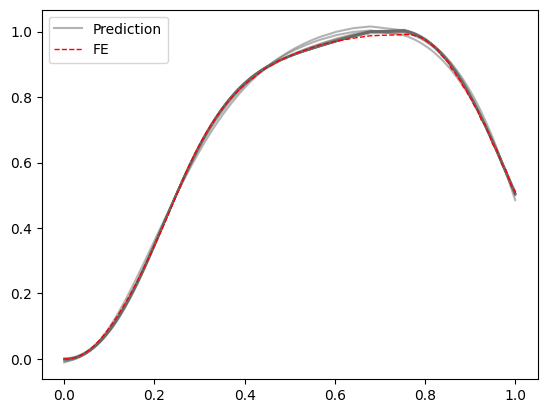

In [21]:
# Evaluation
u_pred = u_pred_fn(params, F[:,0], F[:,1])
u_pred_v = u_pred.reshape([-1,1])
error = np.linalg.norm(u_pred_v - U) / np.linalg.norm(U)
print('Relative l2 error: {:.3e}'.format(error))

# Plot the prediction
pl = x[20]   # part length location

for pred in all_test_preds[2:-1]: # Ignore the first two samples
    plt.plot(F[F[:,0]==pl][:,1], pred[:,0][F[:,0]==pl], alpha=0.5, color = 'dimgray')

plt.plot(F[F[:,0]==pl][:,1], all_test_preds[-1][:,0][F[:,0]==pl], alpha=0.5, color = 'dimgray', label = 'Prediction')
plt.plot(F[F[:,0]==pl][:,1], U[F[:,0]==pl], '--', alpha = 1, c = 'red', lw= 1, label = 'FE')
plt.legend()
